# 07 — Advanced Models

**Goal:** Beat the linear baseline with non-linear models.

**Inputs:** `../data/processed/X_train/test_{pos}.csv` · `y_train/test_{pos}.csv` · `final_features.json` · `baseline_results.json`

**Outputs:** `../models/advanced_models.pkl` · `../data/processed/advanced_results.json` · `../figures/07_*.png`

**Next:** `08_evaluation_and_interpretation.ipynb`

---
**Models compared:**
- **Random Forest** — bagging ensemble; robust tree-based baseline
- **XGBoost** — gradient boosting; state-of-the-art on tabular data
- **MLP (Neural Network)** — multi-layer perceptron; captures non-linear feature interactions; works on already-scaled data from notebook 05

**Tuning:** `RandomizedSearchCV` (5-fold, `n_iter=20`) per model per position.

**Baseline targets (notebook 06):** GK 0.712 · DEF 0.764 · MID 0.771 · ATT 0.750

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble         import RandomForestRegressor
from sklearn.neural_network   import MLPRegressor
from sklearn.model_selection  import RandomizedSearchCV
from sklearn.inspection       import permutation_importance
from sklearn.metrics          import r2_score, mean_squared_error, mean_absolute_error

try:
    from xgboost import XGBRegressor
    XGB_AVAILABLE = True
    print('XGBoost available ✓')
except ImportError:
    XGB_AVAILABLE = False
    print('XGBoost not found — install with: pip install xgboost')

PROC_PATH    = '../data/processed/'
MODELS_PATH  = '../models/'
FIGURES_PATH = '../figures/'
os.makedirs(MODELS_PATH,  exist_ok=True)
os.makedirs(FIGURES_PATH, exist_ok=True)

POSITIONS    = ['GK', 'DEF', 'MID', 'ATT']
RANDOM_STATE = 42

XGBoost available ✓


## 1. Load Data & Baseline

In [7]:
with open(PROC_PATH + 'final_features.json') as f:
    FINAL_FEATURES = json.load(f)

with open(PROC_PATH + 'baseline_results.json') as f:
    baseline_results = json.load(f)

BASELINE_R2 = {
    pos: max(baseline_results[pos][m]['test']['R2'] for m in baseline_results[pos])
    for pos in POSITIONS
}

data = {}
for pos in POSITIONS:
    p = pos.lower()
    X_train = pd.read_csv(PROC_PATH + f'X_train_{p}.csv', index_col=0)
    X_test  = pd.read_csv(PROC_PATH + f'X_test_{p}.csv',  index_col=0)
    y_train = pd.read_csv(PROC_PATH + f'y_train_{p}.csv', index_col=0).squeeze()
    y_test  = pd.read_csv(PROC_PATH + f'y_test_{p}.csv',  index_col=0).squeeze()
    data[pos] = (X_train, X_test, y_train, y_test)
    print(f'  {pos}: train={len(X_train):,}  test={len(X_test):,}  baseline R²={BASELINE_R2[pos]:.3f}')

  GK: train=2,650  test=663  baseline R²=0.712
  DEF: train=7,893  test=1,974  baseline R²=0.764
  MID: train=7,180  test=1,796  baseline R²=0.771
  ATT: train=6,843  test=1,711  baseline R²=0.750


## 2. Evaluation Helper

In [8]:
def evaluate(y_true, y_pred):
    r2         = r2_score(y_true, y_pred)
    rmse       = np.sqrt(mean_squared_error(y_true, y_pred))
    mae        = mean_absolute_error(y_true, y_pred)
    rmse_eur_M = np.sqrt(mean_squared_error(
        np.expm1(y_true), np.expm1(y_pred))) / 1e6
    return {'R2': round(r2, 4), 'RMSE': round(rmse, 4),
            'MAE': round(mae, 4), 'RMSE_EUR_M': round(rmse_eur_M, 3)}

print('evaluate() ready — R², RMSE (log), MAE (log), RMSE (€M)')

evaluate() ready — R², RMSE (log), MAE (log), RMSE (€M)


## 3. Random Forest — RandomizedSearchCV

In [9]:
RF_PARAM_GRID = {
    'n_estimators':      [200, 400, 600],
    'max_depth':         [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf':  [1, 2, 4],
    'max_features':      ['sqrt', 0.5, 0.7],
}

rf_models  = {}
rf_results = {}

for pos in POSITIONS:
    X_train, X_test, y_train, y_test = data[pos]
    search = RandomizedSearchCV(
        RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
        RF_PARAM_GRID, n_iter=20, cv=5, scoring='r2',
        random_state=RANDOM_STATE, n_jobs=-1, verbose=0
    )
    search.fit(X_train, y_train)
    best    = search.best_estimator_
    train_m = evaluate(y_train, best.predict(X_train))
    test_m  = evaluate(y_test,  best.predict(X_test))
    rf_models[pos]  = best
    rf_results[pos] = {'train': train_m, 'test': test_m, 'best_params': search.best_params_}

    delta = test_m['R2'] - BASELINE_R2[pos]
    print(f'  {pos}  train={train_m["R2"]:.3f}  test={test_m["R2"]:.3f}  '
          f'RMSE={test_m["RMSE_EUR_M"]:.2f}M€  Δ={delta:+.3f}  '
          f'{"✓" if delta > 0 else "✗"}')

  GK  train=0.900  test=0.781  RMSE=1.93M€  Δ=+0.069  ✓
  DEF  train=0.903  test=0.826  RMSE=2.01M€  Δ=+0.062  ✓
  MID  train=0.902  test=0.825  RMSE=4.41M€  Δ=+0.054  ✓
  ATT  train=0.899  test=0.802  RMSE=2.71M€  Δ=+0.052  ✓


## 4. XGBoost — RandomizedSearchCV

In [10]:
XGB_PARAM_GRID = {
    'n_estimators':     [200, 400, 600],
    'max_depth':        [3, 4, 5, 6],
    'learning_rate':    [0.01, 0.05, 0.1, 0.15],
    'subsample':        [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'reg_alpha':        [0, 0.1, 0.5, 1.0],
    'reg_lambda':       [1, 2, 5],
}

xgb_models  = {}
xgb_results = {}

if XGB_AVAILABLE:
    for pos in POSITIONS:
        X_train, X_test, y_train, y_test = data[pos]
        search = RandomizedSearchCV(
            XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1,
                         tree_method='hist', verbosity=0),
            XGB_PARAM_GRID, n_iter=20, cv=5, scoring='r2',
            random_state=RANDOM_STATE, n_jobs=1, verbose=0
        )
        search.fit(X_train, y_train)
        best    = search.best_estimator_
        train_m = evaluate(y_train, best.predict(X_train))
        test_m  = evaluate(y_test,  best.predict(X_test))
        xgb_models[pos]  = best
        xgb_results[pos] = {'train': train_m, 'test': test_m, 'best_params': search.best_params_}

        delta = test_m['R2'] - BASELINE_R2[pos]
        print(f'  {pos}  train={train_m["R2"]:.3f}  test={test_m["R2"]:.3f}  '
              f'RMSE={test_m["RMSE_EUR_M"]:.2f}M€  Δ={delta:+.3f}  '
              f'{"✓" if delta > 0 else "✗"}')
else:
    print('Skipped — XGBoost not available.')

  GK  train=0.859  test=0.788  RMSE=1.95M€  Δ=+0.075  ✓
  DEF  train=0.885  test=0.827  RMSE=1.95M€  Δ=+0.062  ✓
  MID  train=0.885  test=0.829  RMSE=4.10M€  Δ=+0.059  ✓
  ATT  train=0.860  test=0.809  RMSE=2.95M€  Δ=+0.058  ✓


## 5. Neural Network (MLP) — RandomizedSearchCV

Multi-layer perceptron from scikit-learn. No extra dependencies — uses the already-scaled
features from notebook 05 (StandardScaler). `early_stopping=True` prevents overfitting
by holding out 10 % of training data as an internal validation set.

In [11]:
MLP_PARAM_GRID = {
    'hidden_layer_sizes': [(64,), (128,), (64, 32), (128, 64), (128, 64, 32), (256, 128, 64)],
    'activation':         ['relu', 'tanh'],
    'alpha':              [1e-4, 1e-3, 1e-2],   # L2 regularisation
    'learning_rate_init': [5e-4, 1e-3, 5e-3],
    'batch_size':         [64, 128, 256],
}

mlp_models  = {}
mlp_results = {}

for pos in POSITIONS:
    X_train, X_test, y_train, y_test = data[pos]
    search = RandomizedSearchCV(
        MLPRegressor(
            max_iter=1000, random_state=RANDOM_STATE,
            early_stopping=True, validation_fraction=0.1, n_iter_no_change=20,
            solver='adam'
        ),
        MLP_PARAM_GRID, n_iter=20, cv=5, scoring='r2',
        random_state=RANDOM_STATE, n_jobs=-1, verbose=0
    )
    search.fit(X_train, y_train)
    best    = search.best_estimator_
    train_m = evaluate(y_train, best.predict(X_train))
    test_m  = evaluate(y_test,  best.predict(X_test))
    mlp_models[pos]  = best
    mlp_results[pos] = {'train': train_m, 'test': test_m, 'best_params': search.best_params_}

    delta = test_m['R2'] - BASELINE_R2[pos]
    print(f'  {pos}  train={train_m["R2"]:.3f}  test={test_m["R2"]:.3f}  '
          f'RMSE={test_m["RMSE_EUR_M"]:.2f}M€  Δ={delta:+.3f}  '
          f'{"✓" if delta > 0 else "✗"}')

  GK  train=0.834  test=0.775  RMSE=2.02M€  Δ=+0.062  ✓
  DEF  train=0.841  test=0.815  RMSE=2.38M€  Δ=+0.051  ✓
  MID  train=0.842  test=0.811  RMSE=5.48M€  Δ=+0.041  ✓
  ATT  train=0.830  test=0.800  RMSE=3.06M€  Δ=+0.049  ✓


## 6. Full Comparison Table

In [12]:
rows = []
for pos in POSITIONS:
    rows.append({'Position': pos, 'Model': 'Baseline (linear)',
                 'Train R²': '-', 'Test R²': BASELINE_R2[pos],
                 'Test RMSE': '-', 'RMSE (€M)': '-'})

    for label, res in [('RandomForest', rf_results),
                        *([('XGBoost', xgb_results)] if XGB_AVAILABLE else []),
                        ('MLP', mlp_results)]:
        tm = res[pos]['train']; rm = res[pos]['test']
        rows.append({'Position': pos, 'Model': label,
                     'Train R²': tm['R2'], 'Test R²': rm['R2'],
                     'Test RMSE': rm['RMSE'], 'RMSE (€M)': rm['RMSE_EUR_M']})

compare_df = pd.DataFrame(rows)
print(compare_df.to_string(index=False))

Position             Model Train R²  Test R² Test RMSE RMSE (€M)
      GK Baseline (linear)        -   0.7124         -         -
      GK      RandomForest   0.8998   0.7809    0.6514     1.927
      GK           XGBoost   0.8588   0.7878     0.641     1.952
      GK               MLP   0.8344   0.7749    0.6602     2.022
     DEF Baseline (linear)        -   0.7640         -         -
     DEF      RandomForest   0.9031   0.8259    0.6359     2.007
     DEF           XGBoost   0.8852   0.8265    0.6348     1.953
     DEF               MLP   0.8407   0.8154    0.6547      2.38
     MID Baseline (linear)        -   0.7706         -         -
     MID      RandomForest   0.9021   0.8251    0.6662     4.405
     MID           XGBoost   0.8851   0.8294     0.658     4.097
     MID               MLP   0.8418   0.8115    0.6917      5.48
     ATT Baseline (linear)        -   0.7504         -         -
     ATT      RandomForest   0.8986   0.8021    0.6945      2.71
     ATT           XGBoos

## 7. R² Comparison Plot

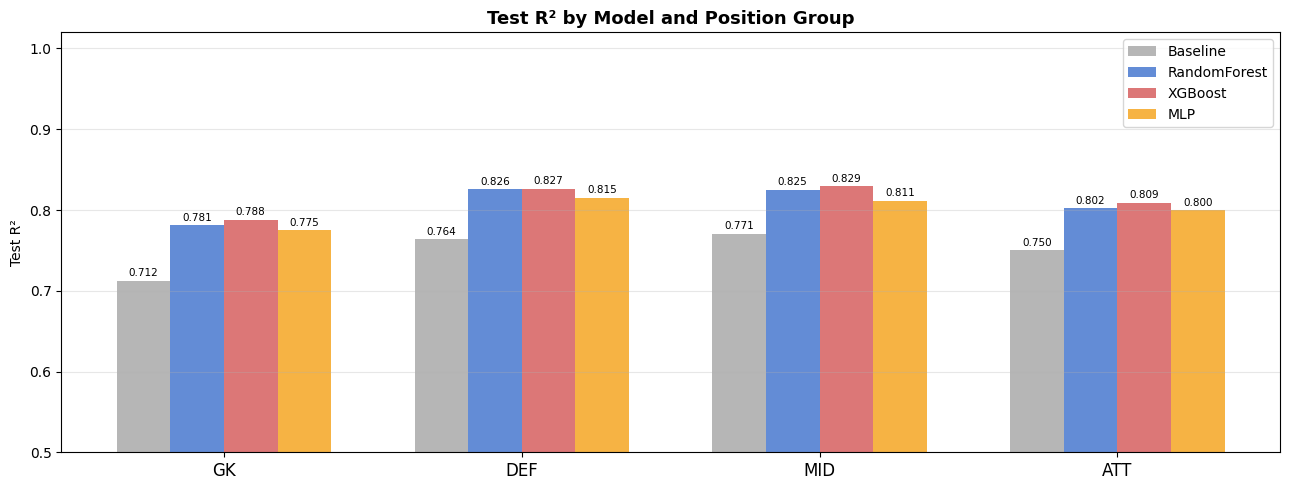

Saved figure.


In [13]:
model_labels = ['Baseline', 'RandomForest', 'MLP']
model_colors = ['#AAAAAA',  '#4878CF',      '#F5A623']
if XGB_AVAILABLE:
    model_labels.insert(2, 'XGBoost')
    model_colors.insert(2, '#D65F5F')

def get_r2(label, pos):
    if label == 'Baseline':     return BASELINE_R2[pos]
    if label == 'RandomForest': return rf_results[pos]['test']['R2']
    if label == 'XGBoost':      return xgb_results[pos]['test']['R2']
    if label == 'MLP':          return mlp_results[pos]['test']['R2']

n      = len(model_labels)
x      = np.arange(len(POSITIONS))
width  = 0.18
offsets = np.linspace(-(n-1)*width/2, (n-1)*width/2, n)

fig, ax = plt.subplots(figsize=(13, 5))
for label, color, offset in zip(model_labels, model_colors, offsets):
    vals = [get_r2(label, pos) for pos in POSITIONS]
    bars = ax.bar(x + offset, vals, width, label=label, color=color, alpha=0.85)
    for bar, v in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.003,
                f'{v:.3f}', ha='center', va='bottom', fontsize=7.5)

ax.set_xticks(x)
ax.set_xticklabels(POSITIONS, fontsize=12)
ax.set_ylabel('Test R²')
ax.set_ylim(0.5, 1.02)
ax.set_title('Test R² by Model and Position Group', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURES_PATH + '07_r2_comparison.png')
plt.show()
print('Saved figure.')

## 8. Select Best Advanced Model per Position

In [14]:
best_advanced         = {}
best_advanced_results = {}

print('Best advanced model per position (by test R²):')
for pos in POSITIONS:
    candidates = [
        ('RandomForest', rf_models[pos],  rf_results[pos]),
        ('MLP',          mlp_models[pos], mlp_results[pos]),
    ]
    if XGB_AVAILABLE:
        candidates.append(('XGBoost', xgb_models[pos], xgb_results[pos]))

    best_name, best_model, best_res = max(candidates, key=lambda t: t[2]['test']['R2'])
    best_advanced[pos]         = best_model
    best_advanced_results[pos] = {'name': best_name, **best_res}

    improvement = best_res['test']['R2'] - BASELINE_R2[pos]
    print(f'  {pos}: {best_name:<15}  '
          f'test R²={best_res["test"]["R2"]:.3f}  '
          f'RMSE={best_res["test"]["RMSE_EUR_M"]:.2f}M€  '
          f'vs baseline: {improvement:+.3f}')

Best advanced model per position (by test R²):
  GK: XGBoost          test R²=0.788  RMSE=1.95M€  vs baseline: +0.075
  DEF: XGBoost          test R²=0.827  RMSE=1.95M€  vs baseline: +0.062
  MID: XGBoost          test R²=0.829  RMSE=4.10M€  vs baseline: +0.059
  ATT: XGBoost          test R²=0.809  RMSE=2.95M€  vs baseline: +0.058


## 9. Actual vs Predicted — Best Model per Position (Test Set)

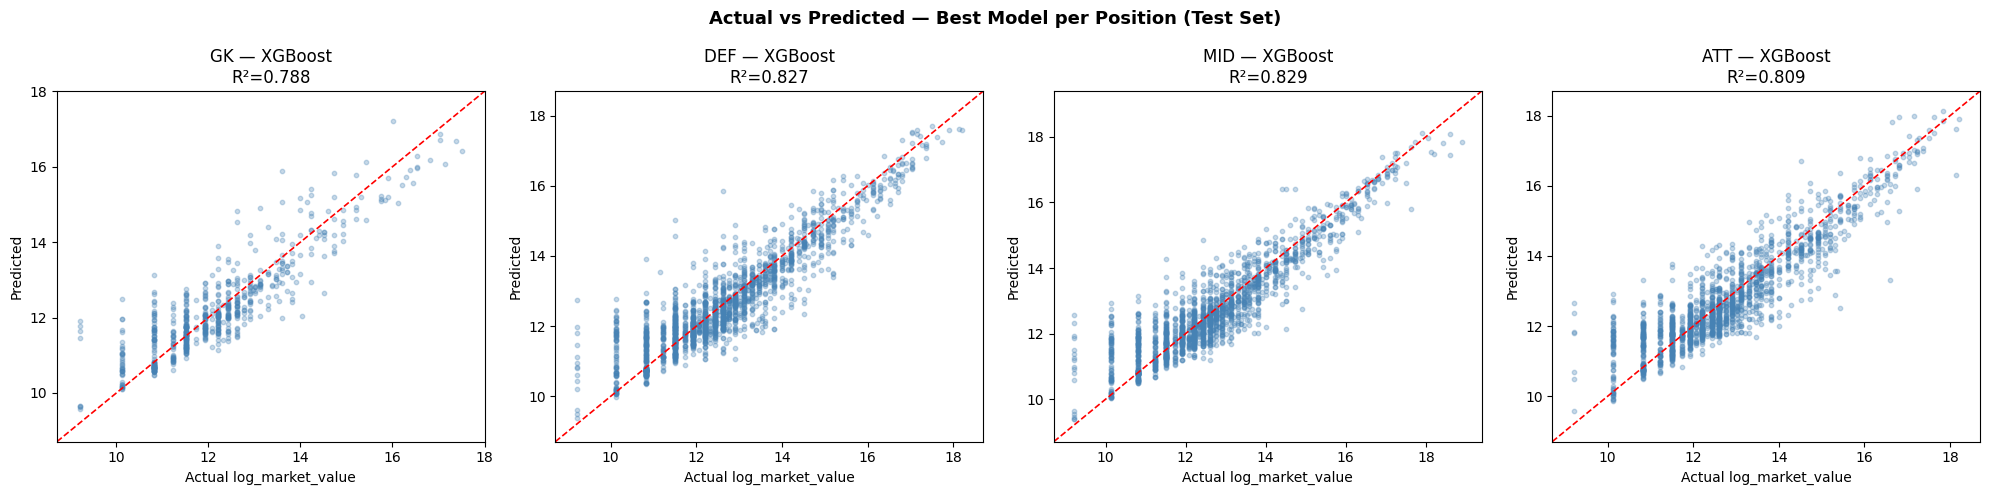

Saved figure.


In [15]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for ax, pos in zip(axes, POSITIONS):
    X_train, X_test, y_train, y_test = data[pos]
    model  = best_advanced[pos]
    y_pred = model.predict(X_test)
    r2     = best_advanced_results[pos]['test']['R2']
    name   = best_advanced_results[pos]['name']

    ax.scatter(y_test, y_pred, alpha=0.3, s=10, color='steelblue')
    lims = [min(y_test.min(), y_pred.min()) - 0.5,
            max(y_test.max(), y_pred.max()) + 0.5]
    ax.plot(lims, lims, 'r--', linewidth=1.2)
    ax.set_xlim(lims); ax.set_ylim(lims)
    ax.set_xlabel('Actual log_market_value')
    ax.set_ylabel('Predicted')
    ax.set_title(f'{pos} — {name}\nR²={r2:.3f}')

plt.suptitle('Actual vs Predicted — Best Model per Position (Test Set)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_PATH + '07_actual_vs_predicted.png')
plt.show()
print('Saved figure.')

## 10. Feature Importance

- RF / XGBoost → built-in `feature_importances_` (fast)
- MLP → permutation importance on test set (model-agnostic; slower but correct)

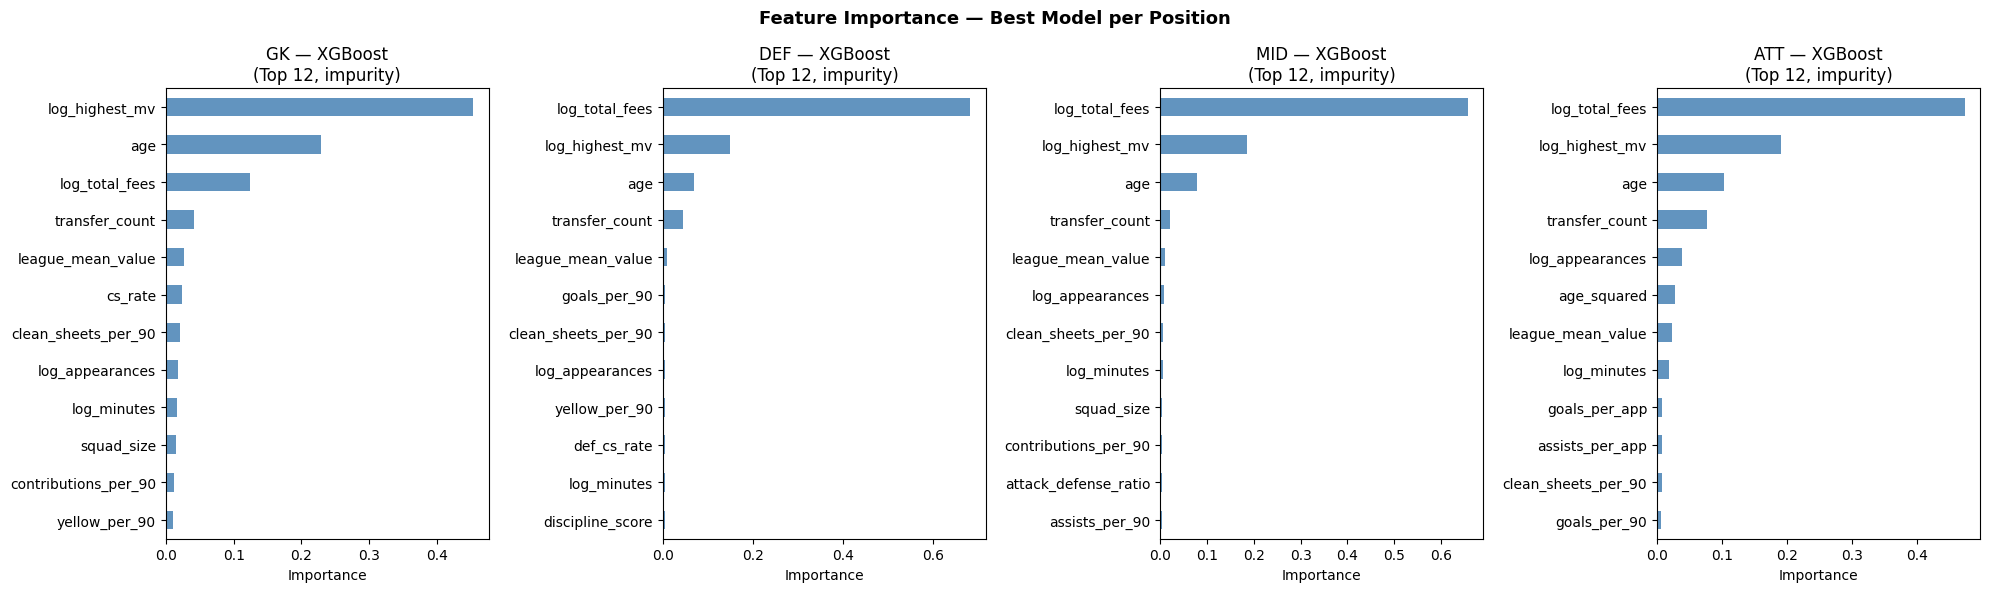

Saved figure.


In [16]:
fig, axes = plt.subplots(1, 4, figsize=(20, 6))

for ax, pos in zip(axes, POSITIONS):
    model = best_advanced[pos]
    feats = FINAL_FEATURES[pos]
    name  = best_advanced_results[pos]['name']
    X_train, X_test, y_train, y_test = data[pos]

    if hasattr(model, 'feature_importances_'):
        # RF or XGBoost — built-in importance
        imp = pd.Series(model.feature_importances_, index=feats)
        method = 'impurity'
    else:
        # MLP — permutation importance on test set
        r = permutation_importance(model, X_test, y_test,
                                   n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1)
        imp = pd.Series(r.importances_mean, index=feats)
        method = 'permutation'

    top = imp.sort_values(ascending=False).head(12)
    top.sort_values().plot(kind='barh', ax=ax, color='steelblue', alpha=0.85)
    ax.set_title(f'{pos} — {name}\n(Top 12, {method})')
    ax.set_xlabel('Importance')

plt.suptitle('Feature Importance — Best Model per Position', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_PATH + '07_feature_importance.png')
plt.show()
print('Saved figure.')

## 11. Best Hyperparameters per Position

In [17]:
print('Best hyperparameters:')
for pos in POSITIONS:
    name   = best_advanced_results[pos]['name']
    params = best_advanced_results[pos]['best_params']
    print(f'\n  {pos} ({name}):')
    for k, v in sorted(params.items()):
        print(f'    {k:<25} {v}')

Best hyperparameters:

  GK (XGBoost):
    colsample_bytree          1.0
    learning_rate             0.01
    max_depth                 4
    min_child_weight          5
    n_estimators              600
    reg_alpha                 0.1
    reg_lambda                5
    subsample                 1.0

  DEF (XGBoost):
    colsample_bytree          1.0
    learning_rate             0.05
    max_depth                 5
    min_child_weight          5
    n_estimators              200
    reg_alpha                 1.0
    reg_lambda                1
    subsample                 0.9

  MID (XGBoost):
    colsample_bytree          1.0
    learning_rate             0.05
    max_depth                 5
    min_child_weight          5
    n_estimators              200
    reg_alpha                 1.0
    reg_lambda                1
    subsample                 0.9

  ATT (XGBoost):
    colsample_bytree          0.8
    learning_rate             0.05
    max_depth                 4
    m

## 12. Validation

In [18]:
errors = []

for pos in POSITIONS:
    X_train, X_test, y_train, y_test = data[pos]
    model   = best_advanced[pos]
    r2_test  = best_advanced_results[pos]['test']['R2']
    r2_train = best_advanced_results[pos]['train']['R2']

    # 1. Beats baseline
    if r2_test <= BASELINE_R2[pos]:
        errors.append(f'{pos}: R²={r2_test:.3f} does not beat baseline {BASELINE_R2[pos]:.3f}')
    else:
        print(f'✓  {pos}: beats baseline  ({r2_test:.3f} > {BASELINE_R2[pos]:.3f})')

    # 2. No severe overfitting (gap < 0.12)
    gap = r2_train - r2_test
    if gap > 0.12:
        errors.append(f'{pos}: train/test R² gap={gap:.3f} — possible overfitting')
    else:
        print(f'✓  {pos}: train/test gap={gap:.3f}')

    # 3. Predictions are finite
    preds = model.predict(X_test)
    if not np.isfinite(preds).all():
        errors.append(f'{pos}: non-finite predictions')
    else:
        print(f'✓  {pos}: all predictions finite')

    print()

print('=' * 55)
if errors:
    print(f'FAILED — {len(errors)} issue(s):')
    for e in errors:
        print(f'  ✗  {e}')
else:
    print('ALL CHECKS PASSED ✓')
    print('\nR² targets for notebook 08 (SHAP):')
    for pos in POSITIONS:
        r2   = best_advanced_results[pos]['test']['R2']
        name = best_advanced_results[pos]['name']
        print(f'  {pos}: {name}  R²={r2:.3f}')
print('=' * 55)

✓  GK: beats baseline  (0.788 > 0.712)
✓  GK: train/test gap=0.071
✓  GK: all predictions finite

✓  DEF: beats baseline  (0.827 > 0.764)
✓  DEF: train/test gap=0.059
✓  DEF: all predictions finite

✓  MID: beats baseline  (0.829 > 0.771)
✓  MID: train/test gap=0.056
✓  MID: all predictions finite

✓  ATT: beats baseline  (0.809 > 0.750)
✓  ATT: train/test gap=0.051
✓  ATT: all predictions finite

ALL CHECKS PASSED ✓

R² targets for notebook 08 (SHAP):
  GK: XGBoost  R²=0.788
  DEF: XGBoost  R²=0.827
  MID: XGBoost  R²=0.829
  ATT: XGBoost  R²=0.809


## 13. Save Outputs

In [19]:
# Best model per position (used by notebooks 08 and 09)
with open(MODELS_PATH + 'advanced_models.pkl', 'wb') as f:
    pickle.dump(best_advanced, f)

# All model results for reporting
all_results = {}
for pos in POSITIONS:
    all_results[pos] = {
        'RandomForest': rf_results[pos],
        'MLP':          mlp_results[pos],
        'best':         best_advanced_results[pos],
    }
    if XGB_AVAILABLE:
        all_results[pos]['XGBoost'] = xgb_results[pos]

with open(PROC_PATH + 'advanced_results.json', 'w') as f:
    json.dump(all_results, f, indent=2)

print(f'Saved → {MODELS_PATH}advanced_models.pkl')
print(f'Saved → {PROC_PATH}advanced_results.json')
print()
print(f'{"Position":<8} {"Model":<16} {"Test R²":>8} {"RMSE (€M)":>10} {"vs Baseline":>12}')
print('-' * 58)
for pos in POSITIONS:
    r = best_advanced_results[pos]
    d = r['test']['R2'] - BASELINE_R2[pos]
    print(f'{pos:<8} {r["name"]:<16} {r["test"]["R2"]:>8.3f} '
          f'{r["test"]["RMSE_EUR_M"]:>10.2f} {d:>+12.3f}')

Saved → ../models/advanced_models.pkl
Saved → ../data/processed/advanced_results.json

Position Model             Test R²  RMSE (€M)  vs Baseline
----------------------------------------------------------
GK       XGBoost             0.788       1.95       +0.075
DEF      XGBoost             0.827       1.95       +0.062
MID      XGBoost             0.829       4.10       +0.059
ATT      XGBoost             0.809       2.95       +0.058
